In [1]:
import coursierapi._
interp.repositories() ++= Seq(
      MavenRepository.of("https://jitpack.io")
  )

import coursierapi._


In [2]:
// Import mathlib
import $ivy.`com.github.markblokpoel.mathlib::mathlib:-SNAPSHOT`
import mathlib.set.SetTheory._
import scala.util.Random

// Import json and io
import $ivy.`org.json4s::json4s-ast:4.0.4`
import $ivy.`org.json4s::json4s-native:4.0.4`
import org.json4s._
import org.json4s.JsonDSL._
import org.json4s.native.JsonMethods._
import java.io._

// Import plotly
import $ivy.`org.plotly-scala::plotly-almond:0.8.1`
import plotly._
import plotly.element._
import plotly.layout._
import plotly.Almond._

import $ivy.$                                                   

import mathlib.set.SetTheory._

import scala.util.Random

// Import json and io

import $ivy.$                             

import $ivy.$                                

import org.json4s._

import org.json4s.JsonDSL._

import org.json4s.native.JsonMethods._

import java.io._

// Import plotly

import $ivy.$                                      

import plotly._

import plotly.element._

import plotly.layout._

import plotly.Almond._

## The unweighted model

<span style="font-variant: small-caps;">D'Souza-Enge-Govaart-Slocombe-model (unweighted)</span> model

**Input:** A raw speech input $a \in \mathbb{R}$, where $0\leq a\leq 1$. A set of current phoneme categories $P=\{p_1, p_2, ..., p_n\}$, where each $p_i\in\mathbb{R}$ and $0\leq p_i\leq 1$. A membership threshold $t\in \mathbb{R}$, where $0\leq t\leq 1$.

**Output:** A set of updated phoneme categories $P'$, where $P'=P \cup \{a\}$ if all current phoneme categories differ more than $t$ from $a$, i.e., if $\forall_{p\in P}~|p-a|>t$. Else, $P'=P\setminus p \cup \{\frac{p + a}{2}\}$, where $|p-a|<t$ and $|p-a|$ is minimal.

The function below is an exact implementation of the formal theory. It takes a single raw input, a threshold and a set of current phoneme categories and computes a new set of phoneme categories.

In [3]:
def phonemeCategorizationUnw(
    rawInput: Double,
    threshold: Double,
    currentCategories: Set[Double]
): Set[Double] = {
    require(rawInput >= 0 && rawInput <= 1, "rawInput is not between 0 and 1")
    require(currentCategories.forall(p => p >= 0 && p <= 1), "not all currentCategories are between 0 and 1")
    require(threshold >= 0 && threshold <= 1, "threshold is not between 0 and 1")
    
    def inverseDistance(p1: Double, p2: Double): Double = 1 - math.abs(p1 - p2)
    def distance(p1: Double, p2: Double): Double = math.abs(p1 - p2)

    val closestPhoneme = currentCategories
        .argMax(inverseDistance(_, rawInput))
        .filter(distance(_, rawInput) < threshold)

    if(currentCategories.isEmpty || closestPhoneme.isEmpty) {
        // New category
        currentCategories + rawInput
    } else {
        // Updated category, if multiple are equally close chose at random
        val oldCategory = closestPhoneme.random.get
        val newCategory = (oldCategory + rawInput) / 2
        currentCategories - oldCategory + newCategory
    }
}

defined function phonemeCategorizationUnw

You can use this implementation by itself and consequetively apply it to add new raw inputs to the categorization. The initial phoneme categorization is emtpy.

In [4]:
val out1 = phonemeCategorizationUnw(0.3, 0.05, Set())
val out2 = phonemeCategorizationUnw(0.25, 0.05, out1)
val out3 = phonemeCategorizationUnw(0.5, 0.05, out2)
val out4 = phonemeCategorizationUnw(0.49, 0.05, out3)
val out5 = phonemeCategorizationUnw(0.46, 0.05, out4)

out1: Set[Double] = Set(0.3)
out2: Set[Double] = Set(0.275)
out3: Set[Double] = Set(0.275, 0.5)
out4: Set[Double] = Set(0.275, 0.495)
out5: Set[Double] = Set(0.275, 0.47750000000000004)

It'll be easier if we can automate this, instead of typing by hand. The function below computes the phoneme categorization for a list of inputs, processed in sequence.

In [5]:
def multiPhonemeCategorizationUnw(
    rawInputs: List[Double],
    threshold: Double,
    currentCategories: Set[Double]
): Set[Double] = {
    require(rawInputs.forall(i => i >= 0 && i <= 1), "not all rawInputs are between 0 and 1")
    require(currentCategories.forall(p => p >= 0 && p <= 1), "not all currentCategories are between 0 and 1")
    require(threshold >= 0 && threshold <= 1, "threshold is not between 0 and 1")
    
    if(rawInputs.size == 0) currentCategories
    else multiPhonemeCategorizationUnw(
        rawInputs.tail,
        threshold,
        phonemeCategorizationUnw(rawInputs.head, threshold, currentCategories)
    )
}

defined function multiPhonemeCategorizationUnw

Then the previous four instructions can be ran in one statement. The output below should be the same as the output for ```cat4``` above.

In [6]:
multiPhonemeCategorizationUnw(
    List(0.3, 0.25, 0.5, 0.49),
    threshold = 0.05,
    Set()
)

res5: Set[Double] = Set(0.275, 0.495)

## The weighted model

As a followup to the unweighted model, the group proposed a weighted model where later observed inputs have less impact on the established categories. One possible way to formalize this is to keep all the exemplars for each categorization and compute the weighted average of all exemplars, including the new input. This way, the old inputs are weighed equally, instead of their average only counting for half. The more exemplars, the 'stronger' the weight. Another alternative formalization would be to not keep the exemplars, but to have a decreasing weight with which each new input is weighted before averaged with the category.

<span style="font-variant: small-caps;">D'Souza-Enge-Govaart-Slocombe-model (weighted average)</span> model

**Input:** A raw speech input $a \in \mathbb{R}$, where $0\leq a\leq 1$. A set of current phoneme categories $P=\{p_1, p_2,\dots, p_n\}$, where each $p_i\in\mathbb{R}$ and $0\leq p_i\leq 1$. A set of exemplars $E=\{a_1,\dots,a_m\}$. A partitioning of exemplars $\mathcal{P}=P_1,\dots,P_m$ (i.e., $E=\bigcup_{p\in\mathcal{P}}p$ and $\forall_{p,q\in\mathcal{P}}p\cap q=\varnothing$), where each category is mapped onto exactly one unique partition or the empty set by the bijective function $m:P\rightarrow E\cup\varnothing$. A membership threshold $t\in \mathbb{R}$, where $0\leq t\leq 1$.

**Output:** A set of updated phoneme categories $P'$, where $P'=P \cup \{a\}$ if all current phoneme categories differ more than $t$ from $a$, i.e., if $\forall_{p\in P}~|p-a|>t$, or else $P'=P\setminus p \cup \{\frac{m(p) + a}{|m(p)|+1}\}$, where $|p-a|<t$ and $|p-a|$ is minimal.

Again, first we provide the single input function, but with one deviation from the formalization, namely, we'll also output the exemplars. This is so we can chain call the function like before to process multiple inputs. We'll create a simple data structure for this purpose and later it will prove useful for analysis. In fact, below we'll provide an updated function for the unweighted model that does the same.

In [7]:
case class CategoriesAndExemplars(
    categories: Set[Double],
    exemplars: Map[Double, List[Double]]
)

def phonemeCategorizationWe(
    rawInput: Double,
    threshold: Double,
    currentCategories: Set[Double],
    exemplars: Map[Double, List[Double]]
): CategoriesAndExemplars = {
    require(rawInput >= 0 && rawInput <= 1, "rawInput is not between 0 and 1")
    require(currentCategories.forall(p => p >= 0 && p <= 1), "not all currentCategories are between 0 and 1")
    require(threshold >= 0 && threshold <= 1, "threshold is not between 0 and 1")
    
    def inverseDistance(p1: Double, p2: Double): Double = 1 - math.abs(p1 - p2)
    def distance(p1: Double, p2: Double): Double = math.abs(p1 - p2)
    
    val closestPhoneme = currentCategories
        .argMax(cp => inverseDistance(cp, rawInput))
        .filter(cp => distance(cp, rawInput) < threshold)
    
    if(closestPhoneme.isEmpty || closestPhoneme.isEmpty) {
        // New category
        CategoriesAndExemplars(
            currentCategories + rawInput,
            exemplars + (rawInput -> List(rawInput))
        )
    } else {
        // Updated category
        // if multiple are equally close chose at random
        val oldCategory = closestPhoneme.random.get
        val oldExemplars = exemplars(oldCategory)
    
        val newCategory = (oldExemplars.sum + rawInput) / (oldExemplars.size + 1)
        val newExemplars = oldExemplars :+ rawInput
        
        val newCategories = currentCategories - oldCategory + newCategory
        val newExemplarsForAllCategories = exemplars - oldCategory + (newCategory -> newExemplars)
        
        CategoriesAndExemplars(newCategories, newExemplarsForAllCategories)
    }
}

defined class CategoriesAndExemplars
defined function phonemeCategorizationWe

To use this function, we again need to specify each step manually and additionally we need to grab the current categories and examplars from the previous output. You may notice that the output generated by this function is different than the one for unweighted phoneme categorization, implying that the two theories are not equivalent. Whether or not they differ *meaningfully* will require further analysis.

In [8]:
val outA = phonemeCategorizationWe(0.3, 0.05, Set(), Map())
val outB = phonemeCategorizationWe(0.25, 0.05, outA.categories, outA.exemplars)
val outC = phonemeCategorizationWe(0.5, 0.05, outB.categories, outB.exemplars)
val outD = phonemeCategorizationWe(0.49, 0.05, outC.categories, outC.exemplars)
val outE = phonemeCategorizationWe(0.46, 0.05, outD.categories, outD.exemplars)

outA: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.3),
  exemplars = Map(0.3 -> List(0.3))
)
outB: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.275),
  exemplars = Map(0.275 -> List(0.3, 0.25))
)
outC: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.275, 0.5),
  exemplars = Map(0.275 -> List(0.3, 0.25), 0.5 -> List(0.5))
)
outD: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.275, 0.495),
  exemplars = Map(0.275 -> List(0.3, 0.25), 0.495 -> List(0.5, 0.49))
)
outE: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.275, 0.48333333333333334),
  exemplars = Map(
    0.275 -> List(0.3, 0.25),
    0.48333333333333334 -> List(0.5, 0.49, 0.46)
  )
)

Again, we also implement a function to compute the categorization of multiple phonemes in sequence.

In [9]:
def multiPhonemeCategorizationWe(
    rawInputs: List[Double],
    threshold: Double,
    currentCategories: Set[Double],
    exemplars: Map[Double, List[Double]]
): CategoriesAndExemplars = {
    require(rawInputs.forall(i => i >= 0 && i <= 1), "not all rawInputs are between 0 and 1")
    require(currentCategories.forall(p => p >= 0 && p <= 1), "not all currentCategories are between 0 and 1")
    require(threshold >= 0 && threshold <= 1, "threshold is not between 0 and 1")
    
    if(rawInputs.size == 0) CategoriesAndExemplars(currentCategories, exemplars)
    else {
        val categorization = phonemeCategorizationWe(rawInputs.head, threshold, currentCategories, exemplars)
        multiPhonemeCategorizationWe(
            rawInputs.tail,
            threshold,
            categorization.categories,
            categorization.exemplars
        )
    }
}

defined function multiPhonemeCategorizationWe

And again an example usage, with empty categorization as starting point.

In [10]:
multiPhonemeCategorizationWe(
    List(0.3, 0.25, 0.5, 0.49, 0.46),
    threshold = 0.05,
    Set(),
    Map()
)

res9: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.275, 0.48333333333333334),
  exemplars = Map(
    0.275 -> List(0.3, 0.25),
    0.48333333333333334 -> List(0.5, 0.49, 0.46)
  )
)

## Updated implementation of unweighted categorization

For ease of analysis, this updated implementation also returns the exemplars.

In [11]:
def phonemeCategorizationUnw(
    rawInput: Double,
    threshold: Double,
    currentCategories: Set[Double],
    exemplars: Map[Double, List[Double]]
): CategoriesAndExemplars = {
    require(rawInput >= 0 && rawInput <= 1, "rawInput is not between 0 and 1")
    require(currentCategories.forall(p => p >= 0 && p <= 1), "not all currentCategories are between 0 and 1")
    require(threshold >= 0 && threshold <= 1, "threshold is not between 0 and 1")
    
    def inverseDistance(p1: Double, p2: Double): Double = 1 - math.abs(p1 - p2)
    def distance(p1: Double, p2: Double): Double = math.abs(p1 - p2)

    val closestPhoneme = currentCategories
        .argMax(inverseDistance(_, rawInput))
        .filter(distance(_, rawInput) < threshold)

    if(currentCategories.isEmpty || closestPhoneme.isEmpty) {
        // New category
        CategoriesAndExemplars(
            currentCategories + rawInput,
            exemplars + (rawInput -> List(rawInput))
        )
    } else {
        // Updated category, if multiple are equally close chose at random
        val oldCategory = closestPhoneme.random.get
        val oldExemplars = exemplars(oldCategory)
    
        val newCategory = (oldCategory + rawInput) / 2
        val newExemplars = oldExemplars :+ rawInput
        
        val newCategories = currentCategories - oldCategory + newCategory
        val newExemplarsForAllCategories = exemplars - oldCategory + (newCategory -> newExemplars)
        
        CategoriesAndExemplars(newCategories, newExemplarsForAllCategories)
    }
}

def multiPhonemeCategorizationUnw(
    rawInputs: List[Double],
    threshold: Double,
    currentCategories: Set[Double],
    exemplars: Map[Double, List[Double]]
): CategoriesAndExemplars = {
    require(rawInputs.forall(i => i >= 0 && i <= 1), "not all rawInputs are between 0 and 1")
    require(currentCategories.forall(p => p >= 0 && p <= 1), "not all currentCategories are between 0 and 1")
    require(threshold >= 0 && threshold <= 1, "threshold is not between 0 and 1")
    
    if(rawInputs.size == 0) CategoriesAndExemplars(currentCategories, exemplars)
    else {
        val categorization = phonemeCategorizationUnw(rawInputs.head, threshold, currentCategories, exemplars)
        multiPhonemeCategorizationUnw(
            rawInputs.tail,
            threshold,
            categorization.categories,
            categorization.exemplars
        )
    }
}

defined function phonemeCategorizationUnw
defined function multiPhonemeCategorizationUnw

## Single instance comparison

Here, we take one hand-picked instance and compare the output of the two theories.

In [12]:
val selectedInputs = List(0.4, 0.36, 0.8, 0.71, 0.63, 0.5)
val initialCategorization = Set(0.5) // or Set() or Set(0.25, 0.75) ...
val emptyExemplars = initialCategorization.map(_ -> List()).toMap

val outputUnw = multiPhonemeCategorizationUnw(
    selectedInputs,
    threshold = 0.1,
    initialCategorization,
    exemplars = emptyExemplars
)
val outputWe = multiPhonemeCategorizationWe(
    selectedInputs,
    threshold = 0.1,
    initialCategorization,
    exemplars = emptyExemplars
)

selectedInputs: List[Double] = List(0.4, 0.36, 0.8, 0.71, 0.63, 0.5)
initialCategorization: Set[Double] = Set(0.5)
emptyExemplars: Map[Double, List[Nothing]] = Map(0.5 -> List())
outputUnw: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.755, 0.63, 0.4525),
  exemplars = Map(
    0.755 -> List(0.8, 0.71),
    0.63 -> List(0.63),
    0.4525 -> List(0.4, 0.36, 0.5)
  )
)
outputWe: CategoriesAndExemplars = CategoriesAndExemplars(
  categories = Set(0.38, 0.755, 0.63, 0.5),
  exemplars = Map(
    0.38 -> List(0.4, 0.36),
    0.755 -> List(0.8, 0.71),
    0.63 -> List(0.63),
    0.5 -> List(0.5)
  )
)

# Simulation 1 with random inputs: Increasing number of inputs

Here we generate a list of $N$ raw inputs to see how the theories respond to increasing number of observed phonemes. Running this code multiple times will result in different outputs. Sometimes the categories for both theories are similar, other times they are different. Change the ```numberOfPhonemes``` to manipulate this parameter, and observe the resulting categorizations.

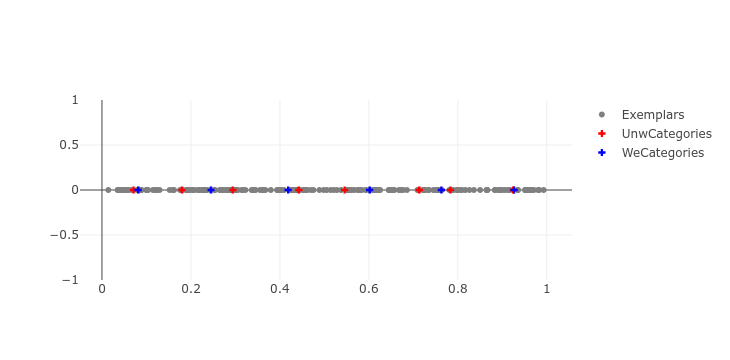

numberOfPhonemes: Int = 200
phonemeInputs: List[Double] = List(
  0.181011564814483,
  0.4352759810000555,
  0.6141881022972793,
  0.23610329648390804,
  0.34518112314371263,
  0.6574358423679207,
  0.5926229295689892,
  0.08765539850277337,
  0.9618277668481786,
  0.9641674750963536,
  0.48888929932691116,
  0.36107919638516195,
  0.98010956256129,
  0.22969158559726088,
  0.4452447678491378,
  0.7544394060079392,
  0.042502559191876066,
  0.1201372779098051,
  0.49851727140133784,
  0.18930594965399428,
  0.7355153179782781,
  0.9353716819652641,
  0.24403965663799365,
  0.8836938192596451,
  0.16202918380040243,
  0.5833457086463331,
  0.6544771433075334,
  0.21463859148659648,
  0.8926678201646496,
  0.6674550453092988,
  0.08409566597697227,
  0.781082841787818,
  0.7452012147362379,
  0.2855794022348557,
  0.8962460642542055,
  0.3365370922334301,
  0.5138406542005727,
  0.28887792915265365,
...
threshold: Double = 0.1
initialCategorization: Set[Double] = Set(0.5)
emptyExemplars:

In [13]:
val numberOfPhonemes = 200
val phonemeInputs = List.tabulate(numberOfPhonemes)(_ => Random.nextDouble)
val threshold = 0.1
val initialCategorization = Set(0.5) // or Set() or Set(0.25, 0.75) ...
val emptyExemplars = initialCategorization.map(_ -> List()).toMap

val outputUnw: CategoriesAndExemplars = multiPhonemeCategorizationUnw(
    phonemeInputs,
    threshold,
    initialCategorization,
    exemplars = emptyExemplars
)
val outputWe: CategoriesAndExemplars = multiPhonemeCategorizationWe(
    phonemeInputs,
    threshold,
    initialCategorization,
    exemplars = emptyExemplars
)

// The code below plots the data in a simple figure.
val data = Seq(
    Scatter(
        phonemeInputs,
        phonemeInputs.map(_ => 0), // hack to plot on a 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker().withColor(Color.StringColor("grey"))
    ).withName("Exemplars"),
    Scatter(
        outputUnw.categories.toList,
        outputUnw.categories.toList.map(_ => 0), // hack to plot on a 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker(symbol = Symbol.Cross()).withColor(Color.StringColor("red"))
    ).withName("UnwCategories"),
    Scatter(
        outputWe.categories.toList,
        outputWe.categories.toList.map(_ => 0), // hack to plot on a second 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker(symbol = Symbol.Cross()).withColor(Color.StringColor("blue"))
    ).withName("WeCategories")
)

plot(data)

The code below saves the data to json file one for the data. You can convert json to a dataframe in R (see [this page](https://www.tutorialspoint.com/r/r_json_files.htm)) or in Python (see [this page](https://pythonbasics.org/pandas-json/)).

In [14]:
def toJson(
    numberOfPhonemes: Int,
    threshold: Double,
    initialCategorization: Set[Double],
    rawInput: List[Double],
    outputUnw: CategoriesAndExemplars,
    outputWe: CategoriesAndExemplars
) = {
    ("simulation" ->
         ("numberOfPhonemes" -> numberOfPhonemes) ~
         ("threshold" -> threshold) ~
         ("initialCategorization" -> initialCategorization) ~
         ("rawInput" -> rawInput) ~
         ("unWeightedCategorization" ->
             outputUnw.exemplars.map { e =>
                 ("category" -> e._1) ~
                 ("exemplars" -> e._2)
             }
         ) ~
         ("weightedCategorization" ->
             outputWe.exemplars.map { e =>
                 ("category" -> e._1) ~
                 ("exemplars" -> e._2)
             }
         ) 
    )
}

val fileID = Random.nextLong.abs

val fileResultsWriter = new PrintWriter(new File(s"f$fileID-phonemes1D-results.json"))

fileResultsWriter.write(
    pretty(
        render(
            toJson(
                numberOfPhonemes,
                threshold,
                initialCategorization,
                phonemeInputs,
                outputUnw,
                outputWe
            )
        )
    )
)

fileResultsWriter.close()

defined function toJson
fileID: Long = 3994898120697721327L
fileResultsWriter: PrintWriter = java.io.PrintWriter@43643a8b

## Simulation2 with random instances: Order effects

Here, we generate random input instances for both problems to compare both. Each time you run the code cell below you generate $N$ raw inputs. The order of that sequence of inputs is randomized to generate two inputs where only the order is different. This is just an example use care to see if there is a qualitative difference between the two theories w.r.t. sensitivity to order effects.

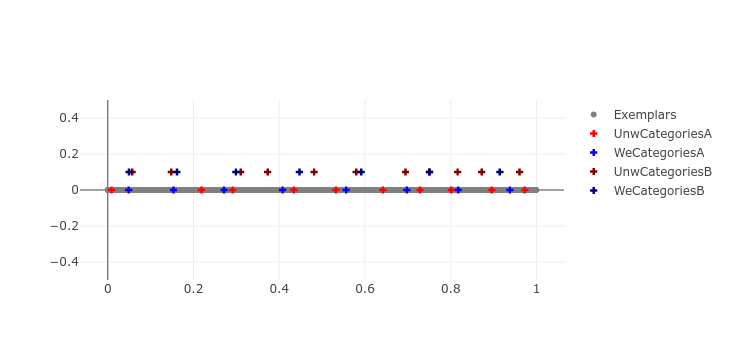

numberOfPhonemes: Int = 2000
phonemeInputsA: List[Double] = List(
  0.5777452101351801,
  0.3501519927976624,
  0.8030737180175963,
  0.9054036100618387,
  0.5676595917055047,
  0.8593549726232343,
  0.24241224542754658,
  0.7015204378457166,
  0.8980468677006296,
  0.13763708627425963,
  0.8215691547821091,
  0.4177980415624183,
  0.12242115024675893,
  0.45558153311171423,
  0.9363206242590723,
  0.14367864478790437,
  0.3911099769174239,
  0.26926720876812127,
  0.49072611496232355,
  0.5649526742080313,
  0.37824581087404807,
  0.8400962759900497,
  0.4250190133733297,
  0.9800062995801367,
  0.2689619747099308,
  0.299630033390477,
  0.19055802134931787,
  0.232528023796858,
  0.1100464541081303,
  0.3291412583673544,
  0.44433037619405924,
  0.7504022232622563,
  0.14859536242416116,
  0.858942780130519,
  0.44741284450902774,
  0.6314938085785461,
  0.13574779788153613,
  0.7091540752786378,
...
phonemeInputsB: List[Double] = List(
  0.9865500964631142,
  0.00901436901710495,
  

In [15]:
val numberOfPhonemes = 2000
val phonemeInputsA = List.tabulate(numberOfPhonemes)(_ => Random.nextDouble)
val phonemeInputsB = Random.shuffle(phonemeInputsA)
val threshold = 0.1
val initialCategorization = Set(0.5) // or Set() or Set(0.25, 0.75) ...
val emptyExemplars = initialCategorization.map(_ -> List()).toMap

val outputUnwA: CategoriesAndExemplars = multiPhonemeCategorizationUnw(
    phonemeInputsA,
    threshold,
    initialCategorization,
    exemplars = emptyExemplars
)
val outputUnwB: CategoriesAndExemplars = multiPhonemeCategorizationUnw(
    phonemeInputsB,
    threshold,
    initialCategorization,
    exemplars = emptyExemplars
)
val outputWeA: CategoriesAndExemplars = multiPhonemeCategorizationWe(
    phonemeInputsA,
    threshold,
    initialCategorization,
    exemplars = emptyExemplars
)
val outputWeB: CategoriesAndExemplars = multiPhonemeCategorizationWe(
    phonemeInputsB,
    threshold,
    initialCategorization,
    exemplars = emptyExemplars
)

// The code below plots the data in a simple figure.
val data = Seq(
    Scatter(
        phonemeInputsA,
        phonemeInputsA.map(_ => 0), // hack to plot on a 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker().withColor(Color.StringColor("grey"))
    ).withName("Exemplars"),
    Scatter(
        outputUnwA.categories.toList,
        outputUnwA.categories.toList.map(_ => 0), // hack to plot on a 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker(symbol = Symbol.Cross()).withColor(Color.StringColor("red"))
    ).withName("UnwCategoriesA"),
    Scatter(
        outputWeA.categories.toList,
        outputWeA.categories.toList.map(_ => 0), // hack to plot on a second 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker(symbol = Symbol.Cross()).withColor(Color.StringColor("blue"))
    ).withName("WeCategoriesA"),
    Scatter(
        outputUnwB.categories.toList,
        outputUnwB.categories.toList.map(_ => 0.1), // hack to plot on a 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker(symbol = Symbol.Cross()).withColor(Color.RGB(128,0,0))
    ).withName("UnwCategoriesB"),
    Scatter(
        outputWeB.categories.toList,
        outputWeB.categories.toList.map(_ => 0.1), // hack to plot on a second 1D line
        mode = ScatterMode(ScatterMode.Markers),
        marker = Marker(symbol = Symbol.Cross()).withColor(Color.RGB(0,0,128))
    ).withName("WeCategoriesB")
)

plot(data, Layout().withYaxis(Axis().withRange(Range.Doubles(-0.5,0.5))))


val fileID = Random.nextLong.abs

val fileResultsWriter = new PrintWriter(new File(s"f$fileID-phonemes1D-order-results.json"))

fileResultsWriter.write(
    pretty(
        render(
            ("simulationA" -> 
                toJson(
                    numberOfPhonemes,
                    threshold,
                    initialCategorization,
                    phonemeInputsA,
                    outputUnwA,
                    outputWeA
                )
            ) ~
            ("simulationB" -> 
                 toJson(
                    numberOfPhonemes,
                    threshold,
                    initialCategorization,
                    phonemeInputsB,
                    outputUnwB,
                    outputWeB
                 )
            )
        )
    )
)

fileResultsWriter.close()